# Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. 

The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. 

Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. <b>Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system.</b> Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# 1 Loading & Cleaning

In [2]:
users = pd.read_json('ultimate_data_challenge.json')
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


## Data types

In [26]:
# change dates to datetime
users['signup_date'] = pd.to_datetime(users['signup_date'])
users['last_trip_date'] = pd.to_datetime(users['last_trip_date'])

In [27]:
# Categoricals
users['city'] = users['city'].astype('category')
users['phone'] = users['phone'].astype('category')

## Missing Values

__Avg Rating of Driver__

This column has the most missing data. Will examine it first. Seems very possible that missing values here would represent a user that never reviewed a driver.

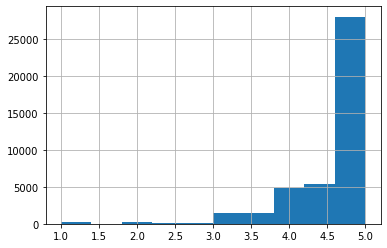

In [4]:
# Avg rating of driver missing the most data - will look at that first
users['avg_rating_of_driver'].hist()

In [5]:
display(users[users['avg_rating_of_driver'].isna()])

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49984,Winterfell,1,2014-01-26,NaN,1.0,2014-01-26,Android,0.0,False,0.0,3.50,5.0
49985,Astapor,1,2014-01-26,NaN,1.0,2014-02-25,Android,0.0,False,100.0,1.38,5.0
49989,Winterfell,1,2014-01-24,NaN,1.0,2014-01-31,iPhone,0.0,False,100.0,0.00,5.0
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0


In [6]:
no_driver_review = users[users['avg_rating_of_driver'].isna()]
no_driver_review['trips_in_first_30_days'].value_counts()

1    3987
0    3749
2     334
3      45
4       6
5       1
Name: trips_in_first_30_days, dtype: int64

It appears that my assumption may be correct. Since most of these riders had 0 or 1 trip, it's highly likey they simply never rated their driver (or, for the ones that never took a trip, never had a driver to rate).

It seems likely something similiar is up with the missing values in the avg_rating_by_driver column too. Will verify:

In [9]:
no_rider_review = users[users['avg_rating_by_driver'].isna()]
no_rider_review['trips_in_first_30_days'].value_counts()

1    103
0     94
2      4
Name: trips_in_first_30_days, dtype: int64

In [10]:
# Assign mean rating to the missing values to minimize the impact they'll have on model
users['avg_rating_of_driver'].fillna(users['avg_rating_of_driver'].mean(), inplace=True)
users['avg_rating_by_driver'].fillna(users['avg_rating_by_driver'].mean(), inplace=True)

__Phone__

In [11]:
users['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [12]:
# Since such a small number, will drop the NaNs from this column
users.dropna(inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


__Check for Outliers/Unusual Values__

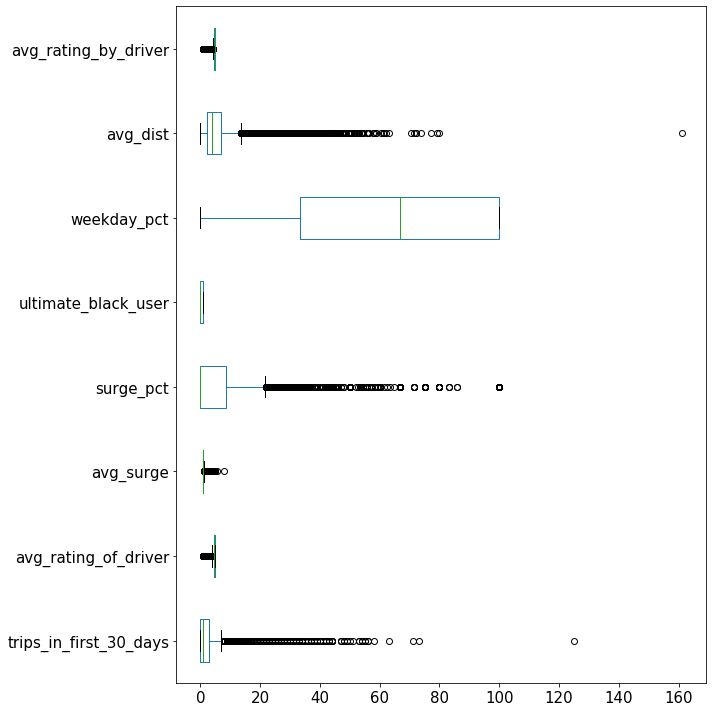

In [13]:
users.boxplot(grid=False, vert=False, fontsize=15, figsize=(10,10))
plt.tight_layout()

None of these values seem extremely out of whack. Even the very high end outliers would still be reasonably feasible, though I am curious about the guy who took over 120 trips in his first 30 days.

In [14]:
users[users['trips_in_first_30_days']>100]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8


In [16]:
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


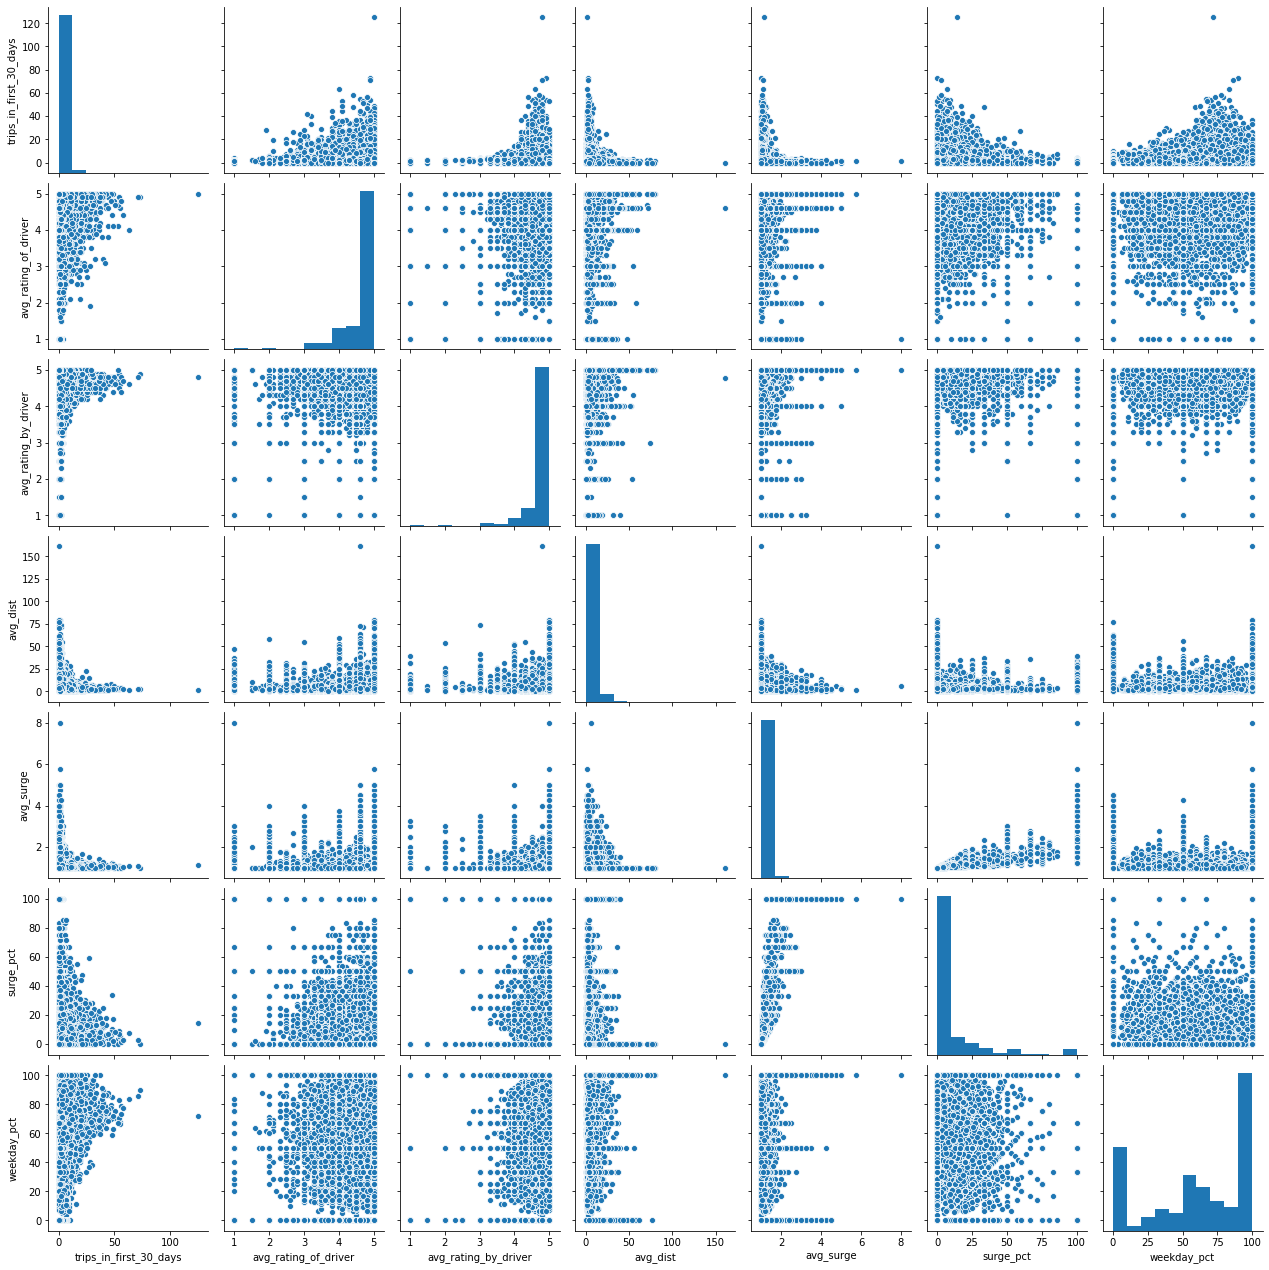

In [23]:
num_cols = users[['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_rating_by_driver','avg_dist',
       'avg_surge','surge_pct','weekday_pct']]
sns.pairplot(num_cols)

I ended up keeping all but around 400 of the users, so we still have a very high percentage of the original dataset.

None of the columns appear highly correlated, so will keep all columns for initial model.

In [28]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  category      
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  category      
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
dtypes: bool(1), category(2), datetime64[ns](2), fl

# 2 Predictive Model

In [30]:
## Create target variable "user_6_mo_later"
users['user_length'] = users['last_trip_date'] - users['signup_date']
users['user_length'].value_counts()

1 days      4324
0 days      2267
2 days      1050
155 days     752
154 days     683
            ... 
24 days      103
60 days      102
38 days       90
180 days      71
181 days      13
Name: user_length, Length: 182, dtype: int64

In [42]:
# still a user after 5 full months?
users['user_6_mo_later'] = [1 if x >= 150 else 0 for x in users['user_length'].dt.days]

In [43]:
users['user_6_mo_later'].value_counts()

0    36975
1    12629
Name: user_6_mo_later, dtype: int64

In [45]:
data = pd.get_dummies(users, columns=['city','phone', 'ultimate_black_user'])
data.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,timedelta,user_length,user_6_mo_later,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,143 days,143 days,0,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,96 days,96 days,0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,1 days,1 days,0,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,170 days,170 days,1,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,47 days,47 days,0,0,0,1,1,0


In [46]:
#data = pd.get_dummies(data, columns=['ultimate_black_user'])
#data.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,timedelta,user_length,user_6_mo_later,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,143 days,143 days,0,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,96 days,96 days,0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,1 days,1 days,0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,170 days,170 days,1,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,47 days,47 days,0,0,0,1,1,0,1,0


In [47]:
data.drop('ultimate_black_user_False', axis=1, inplace=True)
data.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,timedelta,user_length,user_6_mo_later,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,143 days,143 days,0,0,1,0,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,96 days,96 days,0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,1 days,1 days,0,1,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,170 days,170 days,1,0,1,0,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,47 days,47 days,0,0,0,1,1,0,0


In [51]:
data['days_as_user'] = users['user_length'].dt.days
data.drop(['signup_date','last_trip_date','timedelta','user_length'], axis=1, inplace=True)
data.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,user_6_mo_later,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_True,days_as_user
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,0,1,0,0,1,1,143
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,1,0,0,1,0,0,96
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,1,0,0,0,1,0,1
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,0,1,0,0,1,1,170
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,0,1,1,0,0,47


In [53]:
from sklearn.preprocessing import StandardScaler

X = data.drop('user_6_mo_later',axis=1)
y = data['user_6_mo_later']

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [55]:
from sklearn.model_selection import train_test_split

y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=2)

In [56]:
print(X_train.shape)
print(X_test.shape)
print(X_scaled.shape)

(37203, 14)
(12401, 14)
(49604, 14)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth' : np.arange(3,11,2),
    'criterion' : ['entropy', 'gini'],
    'min_samples_leaf' : np.arange(3,11,2)

tree = DecisionTreeClassifier()
    
gs = GridSearchCV(tree, param_grid, verbose=1, cv=5)
gs_results = gs.fit(X_train, y_train)
